### Assessment of Kraken2 vs Kraken2+DLmodel

Input files: <br>
Simulated custom against SHM-seq database (fastq): metameta$*$matchBarcode.fastq<br>
Simulated custom against SHM-seq database (pickle): metameta$*$.pickle<br>
Simulated truth against SHM-seq database: metameta$*$error1_truth.tsv<br>
DL model: model.h5<br>
DL encoder: encoder.h5<br>

In [15]:
import pickle
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from numpy import argmax
from scipy.spatial import distance
import statistics
from functools import reduce
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def parser(filename):
    """
    Generate a list of tuples (header, read)
    """
    fastq_parsed = {}
    try:

        with open(filename) as fq:
            header = next(fq)
            read = next(fq)
            fastq_parsed[header[1:-1].split(' ')[0]] = read[:-1] 
            while True:
                next(fq) # skip + line
                next(fq) # skip qscore
                header = next(fq) # store next read header
                read = next(fq) # store next read seq
                fastq_parsed[header[1:-1].split(' ')[0]] = read[:-1]
    except:
        StopIteration 
    return fastq_parsed

def dna_encode_embedding_table(dna_input, name="dna_encode"):
    embedding_values = np.zeros([len(dna_input), 5], np.float32)
    values = ("A", "C", "G", "T", "N")
    for j, b in enumerate(dna_input):
        if b in values:
            embedding_values[j, values.index(b)] = 1
    return embedding_values

def stack_padding(info_xy):
    # Stack reads into one tensor
    info_xy['one hot tensor'] = info_xy.apply(lambda row: dna_encode_embedding_table(row['read']), axis=1)
    X = np.array(info_xy['one hot tensor'].tolist())

    # Padding to the same sequence length
    masking_value = -1
    max_seq_len = max(len(x) for x in info_xy['one hot tensor'].tolist())
    N = X.shape[0]
    dimension = 5

    Xpad = np.full((N, max_seq_len, dimension), fill_value=masking_value)
    for s, x in enumerate(X):
        seq_len = x.shape[0]
        Xpad[s, 0:seq_len, :] = x
        
    return Xpad

def extract_taxa_info(info_xy, column_header):
    y_taxaorder = info_xy[column_header].tolist()
    y_fastqH = info_xy['fastq'].tolist()
    
    return y_taxaorder, y_fastqH

def predict_taxa_in_model(Xpad, model):
    predictions = model.predict(Xpad)
    
    return predictions

def calculate_missclassified(sant, forutspadd):
    """
    Calculates True postives, false negatives, # NAs and misclassifed taxa when comparing predicted taxa with the 
    groud truth. 
    """
    # percentage of misclassified examples
    if len(sant) != len(forutspadd):
        print('Ground truth and predicted are not the same length.')
        
    true_positives = 0
    missclassified_count = 0
    NA_count = 0
    false_positive = 0
    for pp, prediction in enumerate(forutspadd):
        if prediction == sant[pp]:
            true_positives += 1
        else:
            missclassified_count +=1
            if prediction == 'NA':
                NA_count +=1
            else:
                false_positive +=1

    # Percetage
    TP = true_positives / len(forutspadd) 
    FN = false_positive / len(forutspadd)
    NA = NA_count / len(forutspadd)
    misclassified = missclassified_count / len(forutspadd)
    
    return TP, FN, NA, misclassified

def change_order(row):
    rv_row = row.split(',')
    rv_row.reverse()
    return ','.join(rv_row) # return species level

def rm_specie(row):
    rv_row = row.split(',')
    if len(rv_row) == 7:
        return ','.join(rv_row[1:]) # return genus level
    else:
        return ','.join(rv_row) # return genus level

In [21]:
from matplotlib.text import Text
import matplotlib.pyplot as plt
from matplotlib import transforms, lines
import matplotlib.transforms as mtransforms
from matplotlib.font_manager import FontProperties
from seaborn.utils import remove_na
import statsmodels.stats.multitest as multi

from scipy import stats
DEFAULT = object()

def stat_test(box_data1, box_data2, test):
    test_short_name = ''
    formatted_output = None
    if test == 'Wilcoxon':
        u_stat, pval = stats.ranksums(box_data1, box_data2)
        test_short_name = 'Wilcox'
        formatted_output = ("Wilcoxon test P_val={:.3e} U_stat={:.3e}"
                           .format(pval, u_stat))
        
    elif test == 'ttest':
        u_stat, pval = stats.ttest_ind(box_data1, box_data2, equal_var=True)
        test_short_name = 'T-test'
        formatted_output = ("T-test P_val={:.3e} U_stat={:.3e}"
                           .format(pval, u_stat))
    return pval, u_stat,formatted_output, test_short_name


def pval_annotation_text(x, pvalue_thresholds):
    singleValue = False
    if type(x) is np.array:
        x1 = x
    else:
        x1 = np.array([x])
        singleValue = True
    # Sort the threshold array
    pvalue_thresholds = pd.DataFrame(pvalue_thresholds).sort_values(by=0, ascending=False).values
    x_annot = pd.Series(["" for _ in range(len(x1))])
    for i in range(0, len(pvalue_thresholds)):
        if (i < len(pvalue_thresholds)-1):
            condition = (x1 <= pvalue_thresholds[i][0]) & (pvalue_thresholds[i+1][0] < x1)
            x_annot[condition] = pvalue_thresholds[i][1]
        else:
            condition = x1 < pvalue_thresholds[i][0]
            x_annot[condition] = pvalue_thresholds[i][1]

    return x_annot if not singleValue else x_annot.iloc[0]


def simple_text(pval, pvalue_format, pvalue_thresholds, test_short_name=None):
    """
    Generates simple text for test name and pvalue
    :param pval: pvalue
    :param pvalue_format: format string for pvalue
    :param test_short_name: Short name of test to show
    :param pvalue_thresholds: String to display per pvalue range
    :return: simple annotation
    """
    # Sort thresholds
    thresholds = sorted(pvalue_thresholds, key=lambda x: x[0])

    # Test name if passed
    text = test_short_name and test_short_name + " " or ""

    for threshold in thresholds:
        if pval < threshold[0]:
            pval_text = "p ≤ {}".format(threshold[1])
            break
    else:
        pval_text = "p = {}".format(pvalue_format).format(pval)

    #return text + pval_text
    return pval_text


def add_stat_annotation(ax,
                        data=None, x=None, y=None, hue=None, order=None, hue_order=None,
                        box_pairs=None,
                        test='t-test_welch', text_format='star', pvalue_format_string=DEFAULT,
                        loc='inside', show_test_name=True, pvalue_thresholds=DEFAULT,
                        use_fixed_offset=False, line_offset_to_box=None, line_offset=None,
                        line_height=0.02, text_offset=1, stack=True,
                        color='0.2', linewidth=1.5, fontsize='medium', verbose=1, multi_corr = False):
    """
    User should use the same argument for the data, x, y, hue, order, hue_order as the seaborn boxplot function.
    line_height is in axes fraction coordinates.
    text_offset is in points.
    box_pairs can be of either form:
    For non-grouped boxplot: [(cat1, cat2), (cat3, cat4)]
    For boxplot grouped by hue: [((cat1, hue1), (cat2, hue2)), ((cat3, hue3), (cat4, hue4))]
    Default pvalue_format_string is "{.3e}".
    pvalue_thresholds is a list of lists or tuples. Default is:
    For "star" text_format:
        [[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, "ns"]]
    For "simple" text_format :
        [[1e-5, "1e-5"], [1e-4, "1e-4"], [1e-3, "0.001"], [1e-2, "0.01"]]
    """

    def find_x_position_box(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        """
        if box_plotter.plot_hues is None:
            cat = boxName
            hueOffset = 0
        else:
            cat = boxName[0]
            hue = boxName[1]
            hueOffset = box_plotter.hue_offsets[box_plotter.hue_names.index(hue)]

        groupPos = box_plotter.group_names.index(cat)
        boxPos = groupPos + hueOffset
        return boxPos


    def get_box_data(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        Here we really have to duplicate seaborn code, because there is not direct access to the
        box_data in the BoxPlotter class.
        """
        if box_plotter.plot_hues is None:
            cat = boxName
        else:
            cat = boxName[0]
            hue = boxName[1]

        i = box_plotter.group_names.index(cat)
        group_data = box_plotter.plot_data[i]

        if box_plotter.plot_hues is None:
            # Draw a single box or a set of boxes
            # with a single level of grouping
            box_data = remove_na(group_data)
        else:
            hue_level = hue
            hue_mask = box_plotter.plot_hues[i] == hue_level
            box_data = remove_na(group_data[hue_mask])

        return box_data

    # Set default values if necessary
    if pvalue_format_string is DEFAULT:
        pvalue_format_string = '{:.3e}'
        simple_format_string = '{:.2f}'
    else:
        simple_format_string = pvalue_format_string

    if pvalue_thresholds is DEFAULT:
        if text_format == "star":
            pvalue_thresholds = [[1e-4, "****"], [1e-3, "***"],
                                 [1e-2, "**"], [0.05, "*"], [1, "ns"]]
        else:
            pvalue_thresholds = [[1e-5, "1e-5"], [1e-4, "1e-4"],
                                 [1e-3, "0.001"], [1e-2, "0.01"]]
    
    fig = plt.gcf()

    valid_list = ['inside', 'outside']
    if loc not in valid_list:
        raise ValueError("loc value should be one of the following: {}.".format(', '.join(valid_list)))
    valid_list = ['Wilcoxon', 'ttest']
    if test not in valid_list:
        raise ValueError("test value should be one of the following: {}.".format(', '.join(valid_list)))

    if verbose >= 1 and text_format == 'star':
        print("pvalue annotation legend:")
        pvalue_thresholds = pd.DataFrame(pvalue_thresholds).sort_values(by=0, ascending=False).values
        for i in range(0, len(pvalue_thresholds)):
            if (i < len(pvalue_thresholds)-1):
                print('{}: {:.2e} < p <= {:.2e}'.format(pvalue_thresholds[i][1], pvalue_thresholds[i+1][0], pvalue_thresholds[i][0]))
            else:
                print('{}: p <= {:.2e}'.format(pvalue_thresholds[i][1], pvalue_thresholds[i][0]))
        print()

    # Create the same BoxPlotter object as seaborn's boxplot
    box_plotter = sns.categorical._BoxPlotter(x, y, hue, data, order, hue_order,
                                              orient=None, width=.8, color=None, palette=None, saturation=.75,
                                              dodge=True, fliersize=5, linewidth=None)
    ylim = ax.get_ylim()
    yrange = ylim[1] - ylim[0]

    if line_offset is None:
        if loc == 'inside':
            line_offset = 0.05
            if line_offset_to_box is None:
                line_offset_to_box = 0.06
        elif loc == 'outside':
            line_offset = 0.03
            line_offset_to_box = line_offset
    else:
        if loc == 'inside':
            if line_offset_to_box is None:
                line_offset_to_box = 0.06
        elif loc == 'outside':
            line_offset_to_box = line_offset
    y_offset = line_offset*yrange
    y_offset_to_box = line_offset_to_box*yrange

    y_stack = []
    annList = []
    test_result_list = []
    multi_corr_list = []
    for box1, box2 in box_pairs:

        valid = None
        group_names = box_plotter.group_names
        hue_names = box_plotter.hue_names
        if box_plotter.plot_hues is None:
            cat1 = box1
            cat2 = box2
            hue1 = None
            hue2 = None
            label1 = '{}'.format(cat1)
            label2 = '{}'.format(cat2)
            valid = cat1 in group_names and cat2 in group_names
        else:
            cat1 = box1[0]
            hue1 = box1[1]
            cat2 = box2[0]
            hue2 = box2[1]
            label1 = '{}_{}'.format(cat1, hue1)
            label2 = '{}_{}'.format(cat2, hue2)
            valid = cat1 in group_names and cat2 in group_names and hue1 in hue_names and hue2 in hue_names

        if valid:
            # Get position of boxes
            x1 = find_x_position_box(box_plotter, box1)
            x2 = find_x_position_box(box_plotter, box2)
            box_data1 = get_box_data(box_plotter, box1)
            box_data2 = get_box_data(box_plotter, box2)
            ymax1 = box_data1.max()
            ymax2 = box_data2.max()

            pval, u_stat,formatted_output, test_short_name = stat_test(box_data1, box_data2, test)
            test_result_list.append({'pvalue':pval, 'test_short_name':test_short_name,
                                   'formatted_output':formatted_output, 'box1':box1, 'box2':box2})
                
            if verbose >= 1:
                print("{} v.s. {}: {}".format(label1, label2, formatted_output))

            if text_format == 'full':
                text = "{} p = {}".format('{}', pvalue_format_string).format(test_short_name, pval)
            elif text_format is None:
                text = None
            elif text_format is 'star':
                text = pval_annotation_text(pval, pvalue_thresholds)
            elif text_format is 'simple':
                test_short_name = show_test_name and test_short_name or ""
                text = simple_text(pval, simple_format_string, pvalue_thresholds,
                                   test_short_name)

            if loc == 'inside':
                yref = max(ymax1, ymax2)
            elif loc == 'outside':
                yref = ylim[1]

            if stack:
                if len(y_stack) > 0:
                    yref2 = max(yref, max(y_stack))
                else:
                    yref2 = yref
            else:
                yref2 = yref

            if len(y_stack) == 0:
                y = yref2 + y_offset_to_box
            else:
                y = yref2 + y_offset
            h = line_height*yrange
            lineX, lineY = [x1, x1, x2, x2], [y, y + h, y + h, y]
            if loc == 'inside':
                ax.plot(lineX, lineY, lw=linewidth, c=color)
            elif loc == 'outside':
                line = lines.Line2D(lineX, lineY, lw=linewidth, c=color, transform=ax.transData)
                line.set_clip_on(False)
                ax.add_line(line)

            if text is not None:
                ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                                  xytext=(0, text_offset), textcoords='offset points',
                                  xycoords='data', ha='center', va='bottom', fontsize=fontsize,
                                  clip_on=False, annotation_clip=False)
                annList.append(ann)

            ax.set_ylim((ylim[0], 1.1*(y + h)))

            if text is not None:
                plt.draw()
                y_top_annot = None
                got_mpl_error = False
                if not use_fixed_offset:
                    try:
                        bbox = ann.get_window_extent()
                        bbox_data = bbox.transformed(ax.transData.inverted())
                        y_top_annot = bbox_data.ymax
                    except RuntimeError:
                        got_mpl_error = True

                if use_fixed_offset or got_mpl_error:
                    if verbose >= 1:
                        print("Warning: cannot get the text bounding box. Falling back to a fixed y offset. Layout may be not optimal.")
                    # We will apply a fixed offset in points, based on the font size of the annotation.
                    fontsize_points = FontProperties(size='medium').get_size_in_points()
                    offsetTrans = mtransforms.offset_copy(ax.transData, fig=fig,
                                                          x=0, y=1.0*fontsize_points + text_offset, units='points')
                    yTopDisplay = offsetTrans.transform((0, y + h))
                    y_top_annot = ax.transData.inverted().transform(yTopDisplay)[1]
            else:
                y_top_annot = y + h

            y_stack.append(y_top_annot)
        else:
            raise ValueError("box_pairs contains an unvalid box pair.")
            pass

    y_stack_max = max(y_stack)
    if loc == 'inside':
        ax.set_ylim((ylim[0], 1.03*y_stack_max))
    elif loc == 'outside':
        ax.set_ylim((ylim[0], ylim[1]))
    
    if multi_corr == True:
        corrected_pvals = multiple_correction(multi_corr_list)
        
        for i, corr_p in enumerate(corrected_pvals):
            test_result_list[i]['Corrected pvalue'] = corr_p

    return ax, test_result_list


# Load simulated data

In [4]:
taxa_orders = ["Doamin", "Phylum", "Class", "Order", "Family", "Genus", "Species"]

# Load fastq sample

path = '/simulated/'

# read input fasta file
fq_d = {}
for file in os.listdir(os.path.join(path, 'bacpipe')):
    if file.endswith("_matchBarcode.fastq"):
        name = file.split('_R2')[0]
        
        fastq = parser(os.path.join(path, 'bacpipe', file))

        fq_d[name] = fastq


In [5]:
# Load pickle file
info_d = {}
fastq_spot_d = {}

for file in os.listdir(os.path.join(path, 'bacpipe')):
    if file.endswith(".pickle"):
        name = file.split('_fastq')[0]

        with open(os.path.join(path, 'bacpipe', file), 'rb') as handle:
            b = pickle.load(handle)

        info = pd.DataFrame.from_dict(b, orient='index')

        info['read'] = info['fastq'].map(fq_d[name])

        info['taxa_order'] = info.apply(lambda row: change_order(row['taxa_order']), axis=1)
        info['taxa_order'] = info.apply(lambda row: rm_specie(row['taxa_order']), axis=1)
        
        info_d[name] = info
        
        # For truth - get fastq headers per spot
        tmp_d = {}

        for label, group in info.groupby(['x', 'y']):
            spot = label[0].split(':')[-1] + 'x' + label[1].split(':')[-1]
            tmp_d[spot] = group['fastq'].tolist()
            
        fastq_spot_d[name] = tmp_d


# Load model

In [7]:
input_path = '../../files'
input_model = 'model.h5'

model = keras.models.load_model(os.path.join(input_path, input_model))
# summarize model.
model.summary()

Metal device set to: Apple M1


2023-07-01 10:57:48.480922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-01 10:57:48.481369: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 5)]    0           []                               
                                                                                                  
 masking (Masking)              (None, None, 5)      0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, None, 64)     4864        ['masking[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, None, 64)     5504        ['masking[0][0]']                
                                                                                            

# Load encoder

In [8]:
input_encoder = 'encoder.h5'

encoder = pickle.load(open(os.path.join(input_path, input_encoder), 'rb'))

In [9]:
########### Kraken2 + DL reassignment #############

# Go through all the spots
clusterl_d = {}
reassign_D = {}

for infok, info in info_d.items():

    cluster_l = []
    reassign_d = {} 
    test_count = 0
    unassigned_by_DL = 0
    unassigned_by_DL_fastq = []

    info_coordXY = info.loc[:,['x','y']]
    info_coordXY.drop_duplicates(inplace=True)
    info_coordXY['tuple'] = list(zip(info_coordXY['x'], info_coordXY['y']))

    for tup in info_coordXY['tuple'].tolist():
        newcluster_d = {}

        spot_coord = tup[0].split(':')[-1] + 'x' + tup[1].split(':')[-1]        
        # Select one spot to start with
        info_xy = info[(info['x'] == tup[0]) & (info['y'] == tup[1])]

        if info_xy.shape[0] >0:
            Xpad = stack_padding(info_xy) # Stacking and padding/masking of reads
            y_taxaorder, fastqH = extract_taxa_info(info_xy, 'taxa_order') # Collect taxa info
            predictions = predict_taxa_in_model(Xpad, model) # Predict assignments using model

            rv_predictions = encoder.inverse_transform(predictions.argmax(axis=1)) # Predict taxa using encoder

            # Reassign taxa based on prediciton
            new_taxaorder = []

            for i, taxon in enumerate(y_taxaorder):
                if taxon.startswith('Unassigned'):
                    new_taxa = rv_predictions[i]

                    # If unassigned by DL model
                    if new_taxa == '':
                        new_taxa = unassigned_string
                        unassigned_by_DL += 1
                        unassigned_by_DL_fastq.append(fastqH[i])

                    new_taxaorder.append(new_taxa)
                else:
                    new_taxaorder.append(taxon)

            newcluster_d[spot_coord] = dict(Counter(new_taxaorder))

            reassign_d[spot_coord] = pd.DataFrame({'fastq':fastqH, 'Predicted':new_taxaorder, 'Kraken2':y_taxaorder})

            cluster_l.append(newcluster_d)
            test_count +=1
    
    clusterl_d[infok] = cluster_l
    reassign_D[infok] = reassign_d


2023-07-01 10:58:14.670393: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-01 10:58:15.159290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 10:58:15.567709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 10:58:15.574662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 10:58:16.845875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 10:58:16.852963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 87ms/step


24/24 [==============================] - 2s 86ms/step


16/16 [==============================] - 1s 88ms/step


6/6 [==============================] - 1s 96ms/step


16/16 [==============================] - 1s 92ms/step


26/26 [==============================] - 2s 93ms/step


28/28 [==============================] - 3s 92ms/step


33/33 [==============================] - 3s 93ms/step


11/11 [==============================] - 1s 92ms/step


10/10 [==============================] - 1s 104ms/step


# Evaluation

In [12]:
# Current assignments
tx_rv = ["Species", "Genus", "Family", "Order", "Class", "Phylum", "Doamin"]
truth_d = {}
for file in os.listdir(path):
    if file.endswith("truth.tsv"):
        name = file.split('_truth')[0]
    
        truth = pd.read_csv(os.path.join(path, file))

        truth[tx_rv] = truth["full taxa"].str.split(pat=",", expand=True)

        # Remove Nan in full taxa
        truth.dropna(subset=['full taxa'], inplace=True)
    
        truth_d[name] = truth


In [13]:
#### Bray-Curtis + Pearsons ####

taxa_orders = ["Doamin", "Phylum", "Class", "Order", "Family", "Genus", "Species"]

braycurtis_D = {}
pearson_D = {}

for clusterlK, cluster_l in clusterl_d.items():

    braycurtis_d = {} 
    pearson_d = {}

    for spot in cluster_l:
        for k,v in spot.items():

            ### Predicted assignments
            predicted = pd.DataFrame.from_dict(v, orient='index', columns=['count'])
            predicted.reset_index(inplace=True)
            predicted['index'] = predicted.apply(lambda row: rm_specie(row['index']), axis=1)

            # Separate into taxa levels
            predicted[tx_rv[1:]] = predicted["index"].str.split(pat=",", expand=True)

            ### Truth assignments
            truth_spot = truth_d[clusterlK][truth_d[clusterlK]['index'].isin(fastq_spot_d[clusterlK][k])]

            ### Kraken2 
            kraken = info_d[clusterlK][(info_d[clusterlK]['x'] == 'B1:Z:' + k.split('x')[0]) & (info_d[clusterlK]['y'] == 'B2:Z:' + k.split('x')[1])]
            kraken[tx_rv[1:]] = kraken["taxa_order"].str.split(pat=",", expand=True)

            if truth_spot.shape[0] > 0:

                for level in taxa_orders[1:-1]:

                    pred = predicted.groupby(level)['count'].sum()
                    tru = truth_spot.groupby(level).count()['full taxa']
                    krak = kraken.groupby(level).count()['taxa_order']

                    # Comapre relative abundances using Bray-Curtis dissimilarity
                    bc_d = {}
                    dff = pd.concat([tru, pred, krak], axis=1)
                    dff.columns = ['Truth', 'DL model', 'Kraken2']
                    dff.fillna(0, inplace=True)

                    # Test to compare relative abundances
                    for col in ['Truth', 'DL model', 'Kraken2']:
                        dff[col + '%'] = (dff[col] / dff[col].sum())

                    tru_pred = distance.braycurtis(dff['Truth%'].tolist(), dff['DL model%'].tolist())
                    tru_krak = distance.braycurtis(dff['Truth%'].tolist(), dff['Kraken2%'].tolist())
                    bc_d[level] = [tru_pred, tru_krak] # B-C truth vs predictied, B-C truth vs kraken2

                    if not k in braycurtis_d:
                        braycurtis_d[k] = bc_d
                    else:
                        braycurtis_d[k][level] = [tru_pred, tru_krak] # B-C truth vs predictied, B-C truth vs kraken2

                    # Compare relative abundances with pearson correlation
                    ps_d = {}            
                    tru_pred = stats.pearsonr(dff['Truth%'].tolist(), dff['DL model%'].tolist())[0]
           
                    tru_krak = stats.pearsonr(dff['Truth%'].tolist(), dff['Kraken2%'].tolist())[0]

                    if not np.isnan(tru_pred):
                        ps_d[level] = [tru_pred, tru_krak] # pearson truth vs predictied, B-C truth vs disrupted

                        if not k in pearson_d:
                            pearson_d[k] = ps_d
                        else:
                            pearson_d[k][level] = [tru_pred, tru_krak] # pearson truth vs predictied, eucledian truth vs disrupted            

    braycurtis_D[clusterlK] = braycurtis_d
    pearson_D[clusterlK] = pearson_d   



In [16]:
#### Confusion matrix + Stats ####

stats_D = {}

for reassignK, reassign_d in reassign_D.items():

    cm_d = {}
    stats_d = {}

    for k,v in reassign_d.items():

        ### Truth assignments
        truth_spot = truth_d[reassignK][truth_d[reassignK]['index'].isin(fastq_spot_d[reassignK][k])]
        truth_spot.rename(columns={'index':'fastq'}, inplace=True)

        ### Predicted
        predicted = v[['fastq', 'Predicted']]
        predicted['DL model'] = predicted.apply(lambda row: rm_specie(row['Predicted']), axis=1)
        predicted[tx_rv[1:]] = predicted["DL model"].str.split(pat=",", expand=True)

        ### Kraken2
        kraken = v[['fastq', 'Kraken2']]
        kraken['Kraken2'] = kraken.apply(lambda row: rm_specie(row['Kraken2']), axis=1)
        kraken[tx_rv[1:]] = kraken["Kraken2"].str.split(pat=",", expand=True)

        if truth_spot.shape[0] > 0:

            for level in taxa_orders[1:-1]:

                pred = predicted[['fastq', level]]
                tru = truth_spot[['fastq', level]]
                kra = kraken[['fastq', level]]

                mer = reduce(lambda x,y: pd.merge(x,y, on='fastq', how='outer'), [pred, tru, kra])
                mer.dropna(inplace=True) 

                # Make confusion matrix
                ## Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population.
                cmtmp = {}

                cm_tru_pred = confusion_matrix(mer[level + '_y'].tolist(), mer[level + '_x'].tolist(), normalize='true')
                cm_tru_krak = confusion_matrix(mer[level + '_y'].tolist(), mer[level].tolist(), normalize='true')

                cmtmp[level] = [cm_tru_pred, cm_tru_krak]

                if not k in cm_d:
                    cm_d[k] = cmtmp
                else:
                    cm_d[k][level] = [cm_tru_pred, cm_tru_krak]

                # Calculate stats (unweighted)
                stattmp = {}

                stats_tru_pred = classification_report(mer[level + '_y'].tolist(), mer[level + '_x'].tolist(), 
                                              labels=list(set(mer[level + '_y'].tolist())), 
                                              target_names=list(set(mer[level + '_y'].tolist())), 
                                              sample_weight=None, digits=2, 
                                              output_dict=True, 
                                              zero_division='warn')

                stats_tru_krak = classification_report(mer[level + '_y'].tolist(), mer[level].tolist(), 
                                              labels=list(set(mer[level + '_y'].tolist())), 
                                              target_names=list(set(mer[level + '_y'].tolist())), 
                                              sample_weight=None, digits=2, 
                                              output_dict=True, 
                                              zero_division='warn')

                TP_pred, FN_pred, NA_pred, misclassified_pred = calculate_missclassified(mer[level + '_y'].tolist(), mer[level + '_x'].tolist())
                TP_krak, FN_krak, NA_krak, misclassified_krak = calculate_missclassified(mer[level + '_y'].tolist(), mer[level].tolist())

                try:
                    data_tuples = list(zip([level, 'DL model', stats_tru_pred['accuracy'], stats_tru_pred['macro avg']['f1-score'], FN_pred, NA_pred, misclassified_pred],
                                      [level, 'Kraken2', stats_tru_krak['accuracy'], stats_tru_krak['macro avg']['f1-score'], FN_krak, NA_krak, misclassified_krak]))
                except KeyError:
                    try:
                        data_tuples = list(zip([level, 'DL model', stats_tru_pred['accuracy'], stats_tru_pred['macro avg']['f1-score'], FN_pred, NA_pred, misclassified_pred],
                                      [level, 'Kraken2', stats_tru_krak['micro avg']['recall'], stats_tru_krak['macro avg']['f1-score'], FN_krak, NA_krak, misclassified_krak]))
                    except KeyError:
                        try:
                            data_tuples = list(zip([level, 'DL model', stats_tru_pred['micro avg']['recall'], stats_tru_pred['macro avg']['f1-score'], FN_pred, NA_pred, misclassified_pred],
                                      [level, 'Kraken2', stats_tru_krak['micro avg']['recall'], stats_tru_krak['macro avg']['f1-score'], FN_krak, NA_krak, misclassified_krak]))
                        except KeyError:
                            data_tuples = list(zip([level, 'DL model', stats_tru_pred['micro avg']['recall'], stats_tru_pred['macro avg']['f1-score'], FN_pred, NA_pred, misclassified_pred],
                                      [level, 'Kraken2', stats_tru_krak['accuracy'], stats_tru_krak['macro avg']['f1-score'], FN_krak, NA_krak, misclassified_krak]))


                df_stats = pd.DataFrame(data_tuples, index = ['taxa order', 'type','accuracy', 'F1-score', 'False Pos', 'NAs', 'Misclassified']).T

                stattmp[level] = df_stats

                if not k in stats_d:
                    stats_d[k] = stattmp
                else:
                    stats_d[k][level] = df_stats

        stats_D[reassignK] = stats_d


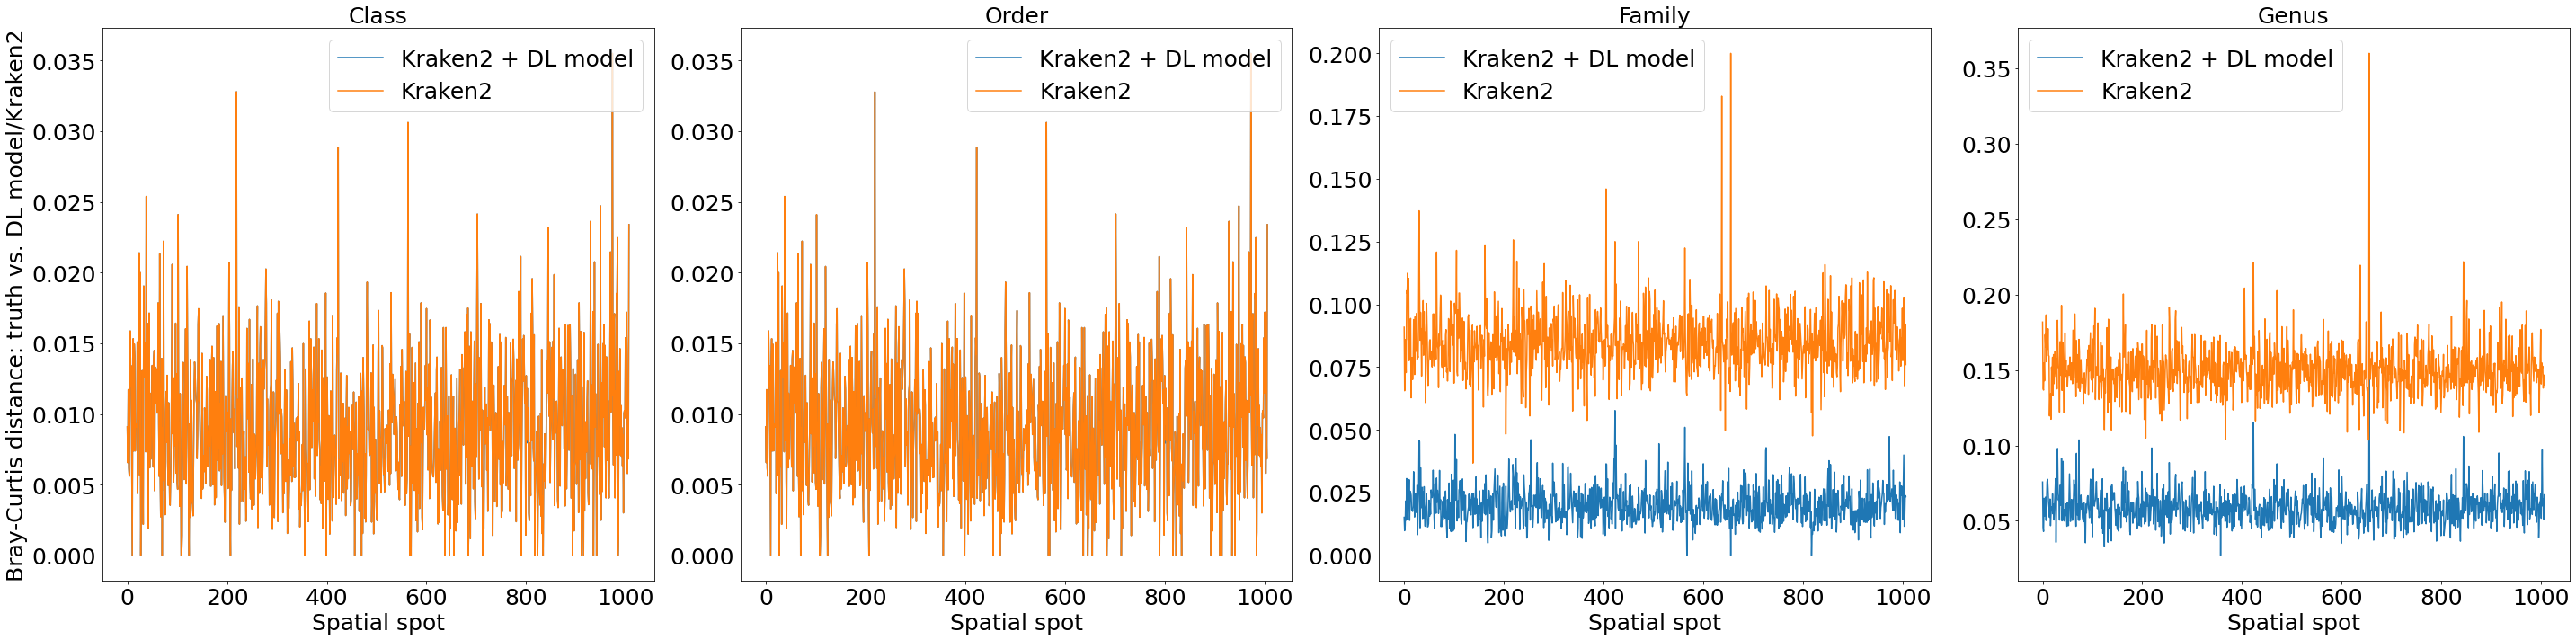

In [17]:
# Plot BC
fig = plt.figure(figsize=(40,10))

# for a 2x2 subplot
axes = []
for row_idx in range(0,1):
    for col_idx in range(0,4):
        ax = plt.subplot2grid((1, 4), (row_idx, col_idx))
        axes.append(ax)
        
bc_df = pd.DataFrame.from_dict(braycurtis_D['metameta_error1'], orient='index')
x = 'index'
y = 'value'
hue = 'variable'        
    
for i, tx in enumerate(taxa_orders[2:-1]):
    
    df2 = pd.DataFrame(bc_df[tx].to_list(), columns=['DL model','Kraken2']).reset_index()
    ax = axes[i]
    df3 = pd.melt(df2, id_vars=['index'], value_vars=['DL model','Kraken2'])
    
    sns.lineplot(x=x, y=y, hue=hue, data=df3, ax=ax)
    ax.set_title(tx, fontsize=25)
    ax.set_xlabel("Spatial spot", fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=25)
    
    if i == 0:
        ax.set_ylabel("Bray-Curtis distance: truth vs. DL model/Kraken2", fontsize=25)
    else:
        ax.set_ylabel("")
    
    # Legend
    L=ax.legend(fontsize=25)
    L.get_texts()[0].set_text('Kraken2 + DL model')
    L.get_texts()[1].set_text('Kraken2')

plt.tight_layout()


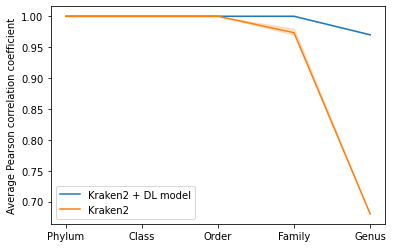

In [18]:
# Calculate average pearson per taxa level
import statistics

P_stats = []

for pck, pearson_d in pearson_D.items():
    p_stats = {}
    for itp, tp in enumerate(['DL model', 'Kraken2']):
        pl=[]
        cl=[]
        ol=[]
        fl=[]
        gl=[]
        l = [pl, cl, ol, fl, gl]


        for k,v in pearson_d.items():

            for i, tx in enumerate(taxa_orders[1:-1]):
                try:
                    l[i].append(v[tx][itp])
                except KeyError:
                    continue
        mean_l = []
        for i, il in enumerate(l):
            mean_l.append(round(sum(il) / len(il), 2))
        p_stats[tp] = mean_l

        
    p_stats['taxa_order'] = taxa_orders[1:-1]   
    p_df = pd.DataFrame(p_stats)
    p_df= pd.melt(p_df, id_vars=['taxa_order'], value_vars=['DL model', 'Kraken2'])
    p_df['name'] = pck
   
    P_stats.append(p_df)

P_stats = pd.concat(P_stats)
P_stats.reset_index(inplace=True)

# Plot
# for a 2x3 subplot
axes = []
for row_idx in range(0,1):
    for col_idx in range(0,1):
        ax = plt.subplot2grid((1, 1), (row_idx, col_idx))
        axes.append(ax)
ax=axes[0]
sns.lineplot(data=P_stats, x='taxa_order', y='value', hue='variable', ax=ax)

ax.set_ylabel("Average Pearson correlation coefficient")
ax.set_xlabel("")

# Legend
L=ax.legend()
L.get_texts()[0].set_text('Kraken2 + DL model')
L.get_texts()[1].set_text('Kraken2')
plt.show()



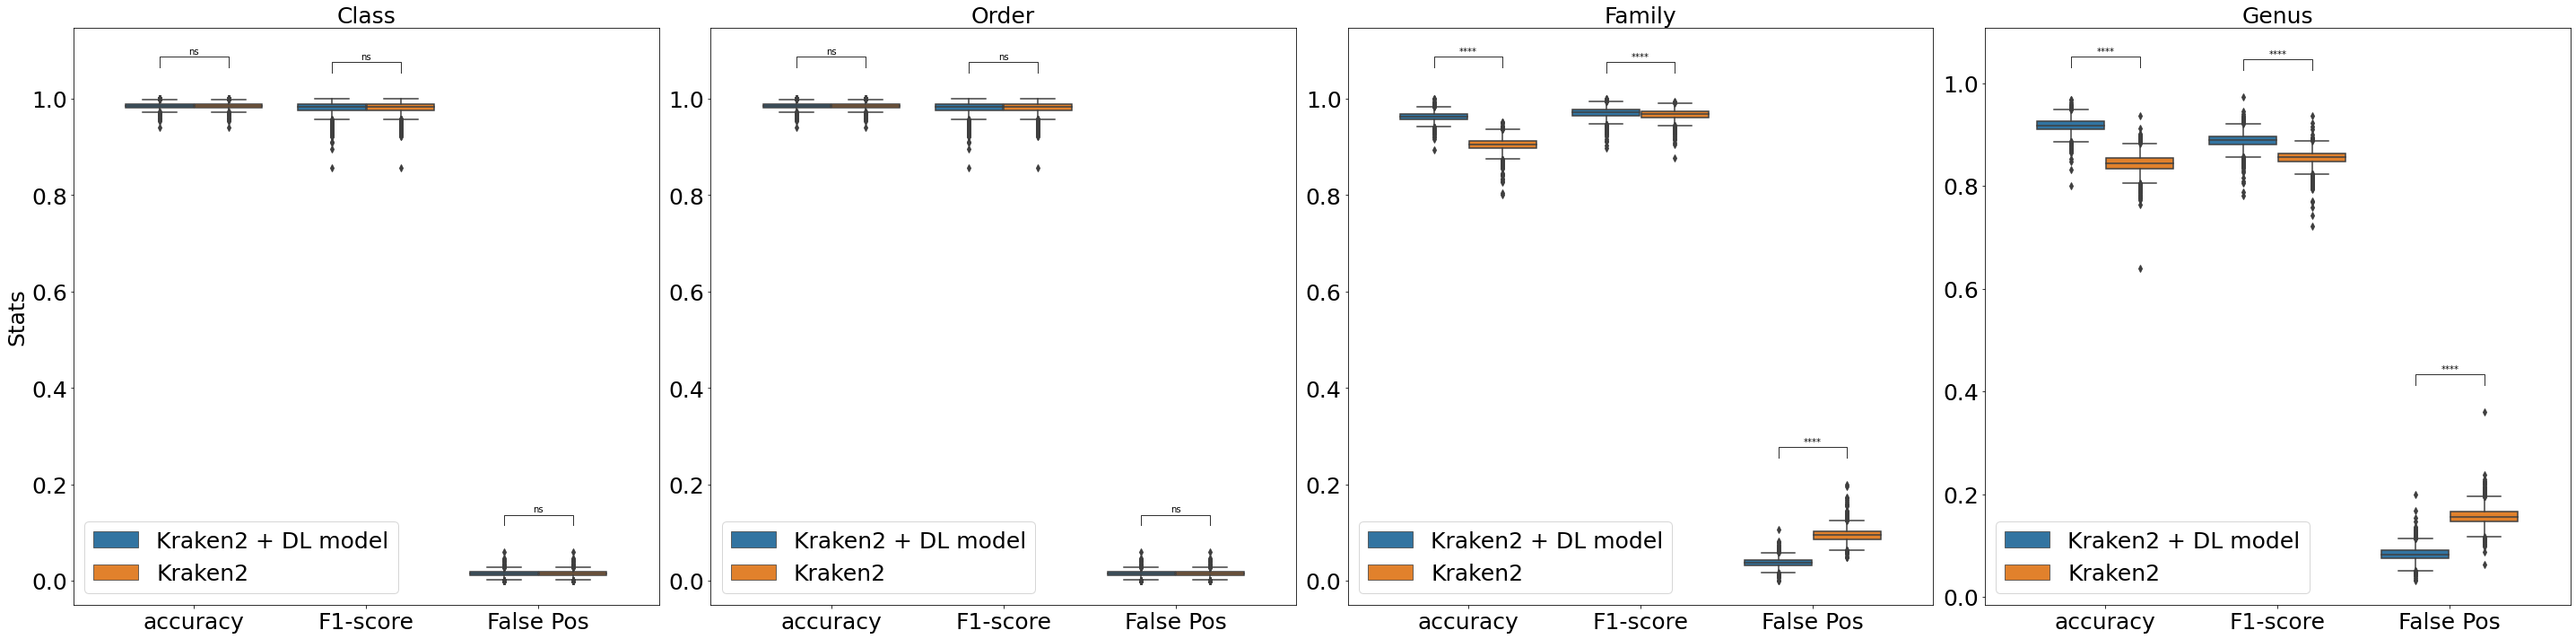

In [22]:
# Average stats_d
l = []

for jk, stats_d in stats_D.items():
    for k,v in stats_d.items():
        for ik, iv in v.items():
            iv['name'] = jk
            l.append(iv)

l2 = pd.concat(l)
l2[['accuracy', 'F1-score', 'False Pos']] = l2[['accuracy', 'F1-score', 'False Pos']].apply(pd.to_numeric)

for i, tx in enumerate(taxa_orders[1:-1]):
    l3 = l2[l2['taxa order'] == tx]
    
fig = plt.figure(figsize=(40,10))

# for a 2x3 subplot
axes = []
for row_idx in range(0,1):
    for col_idx in range(0,4):
        ax = plt.subplot2grid((1, 4), (row_idx, col_idx))
        axes.append(ax)

x = 'variable'
y = 'value'
hue = 'type'
    
for i, tx in enumerate(taxa_orders[2:6]):
    l3 = l2[l2['taxa order'] == tx]
    l3 = pd.melt(l3, id_vars=['type'], value_vars=['accuracy', 'F1-score', 'False Pos'])
    
    ax = axes[i]
    
    sns.boxplot(x=x, y=y, hue=hue, data=l3, ax=ax)
    ax.set_title(tx, fontsize=25)
    ax.set_xlabel("")
    ax.tick_params(axis='both', which='major', labelsize=25)
    
    if i == 0:
        ax.set_ylabel("Stats", fontsize=25)
    else:
        ax.set_ylabel("")
    
    # Legend
    L=ax.legend(fontsize=25, loc='lower left')
    L.get_texts()[0].set_text('Kraken2 + DL model')
    L.get_texts()[1].set_text('Kraken2')
    
    # Add t test    
    boxPairList = [(('accuracy', 'DL model'), ('accuracy','Kraken2')),
                    (('F1-score', 'DL model'), ('F1-score', 'Kraken2')),
               (('False Pos', 'DL model'), ('False Pos', 'Kraken2'))]

    add_stat_annotation(ax, data=l3, x=x, y=y, hue=hue,
                    box_pairs=boxPairList,
                    test='ttest', text_format='star', loc='inside', verbose=0, linewidth=1, stack=False)

plt.tight_layout() 
